# Análise de Dados de MBA

## O Que é MBA (Market Basket Analysis)?

A Análise de Cesta de Compras (Market Basket Analysis) é uma das principais técnicas usadas por grandes varejistas para descobrir associações entre itens. A técnica funciona procurando combinações de itens que ocorrem juntos com frequência nas transações. Em outras palavras, permite que os varejistas identifiquem as relações entre os itens que as pessoas compram.

A Análise de Cesta de Compras emprega algoritmos de regras de associação, que são amplamente utilizadas para analisar cesta de varejo ou dados de transação e têm o objetivo de identificar regras fortes descobertas em dados de transações comerciais usando medidas de interesse, com base no conceito de regras fortes.

### Fonte dos Dados

https://www.kaggle.com/c/instacart-market-basket-analysis/data

"Este é um conjunto de dados relacional de arquivos que descreve os pedidos dos clientes ao longo do tempo. O objetivo é prever quais produtos estarão no próximo pedido de um usuário. O conjunto de dados é anonimo e contém uma amostra de mais de 3 milhões de pedidos de supermercado de mais de 200.000 usuários do Instacart. Para cada usuário, fornecemos entre 4 e 100 de seus pedidos, com a sequência de produtos comprados em cada pedido. Também fornecemos a semana e a hora do dia em que o pedido foi realizado, além de uma medida relativa de tempo entre os pedidos. Para mais informações, veja o post do blog que acompanha seu lançamento público."

## Instalando e Carregando os Pacotes

In [1]:
# Instalar o efficient_apriori utilizado para realizar a análise de associação de itens em conjuntos de dados
!pip install -q efficient_apriori

In [2]:
!pip install -q shutup

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')
import shutup; shutup.please()

## Carregando os Dados

In [4]:
# Carrega os dados
aisle = pd.read_csv('dados/aisles.csv')
department = pd.read_csv('dados/departments.csv')
order = pd.read_csv('dados/orders.csv')
product = pd.read_csv('dados/products.csv')
order_product_prior = pd.read_csv('dados/order_products__prior.csv')

## Análise Exploratória

In [5]:
# Total de registros por dataset
count_array = np.array([['Aisles', len(aisle)],
                        ['Department', len(department)],
                        ['Product', len(product)],
                        ['Order', len(order)],
                        ['Order_Product_Prior', len(order_product_prior)]])
count_record = pd.DataFrame(count_array, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489


In [6]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
# Total de itens nas categorias de eval_set
order['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

## Limpeza dos Dados

### Verificando Valores Ausentes

In [12]:
aisle.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [13]:
department.isna().sum()

department_id    0
department       0
dtype: int64

In [14]:
order.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Verificam-se diversos valores ausentes para a coluna 'days_since_prior_order'. Eles se dão pois em caso de ser a primeira compra do cliente, não existe dias desde a última compra, por isso o valor fica vazio.

In [15]:
product.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [16]:
order_product_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Feature Extraction

### Merge da Tabela order_product_prior com order, product, aisle e department

In [17]:
%%time
# merge
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

Wall time: 2min 4s


In [18]:
order_product_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [19]:
order_product_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [20]:
order_product_prior.isnull().sum() / len(order_product_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Manterei a variável 'days_since_prior_order' por duas razões:

1- O percentual de valores ausentes é apenas de 6.4%.

2- Não usarei a variável com o algoritmo MBA.

## Análise Estatística Descritiva

### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [21]:
# Agrupa os dados por usuário e número do pedido, agregando pelo maior valor
ord_max_count = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
ord_max_count.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [22]:
# Faz a contagem por número de pedidos
ord_max_count = ord_max_count.order_number.value_counts()
ord_max_count.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

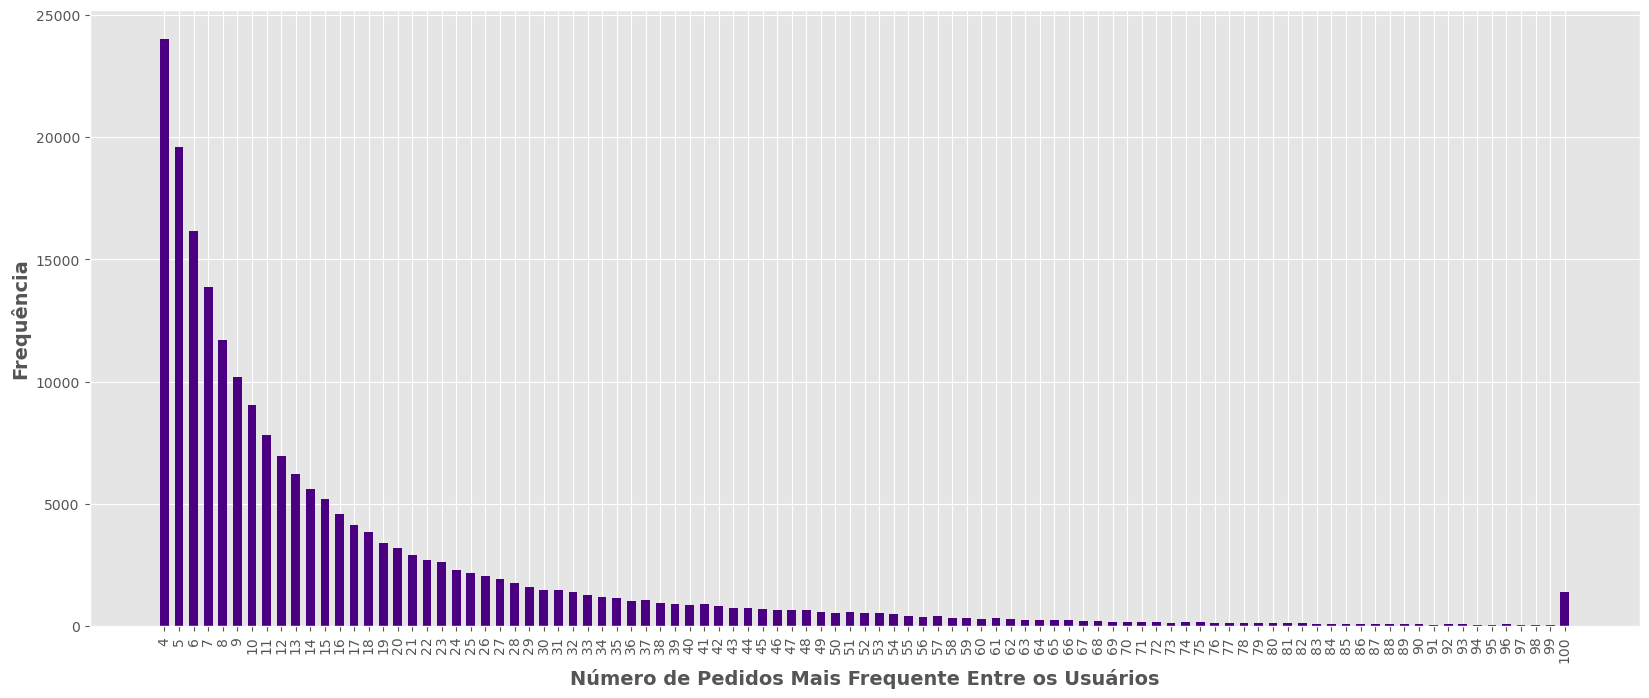

In [23]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [24]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

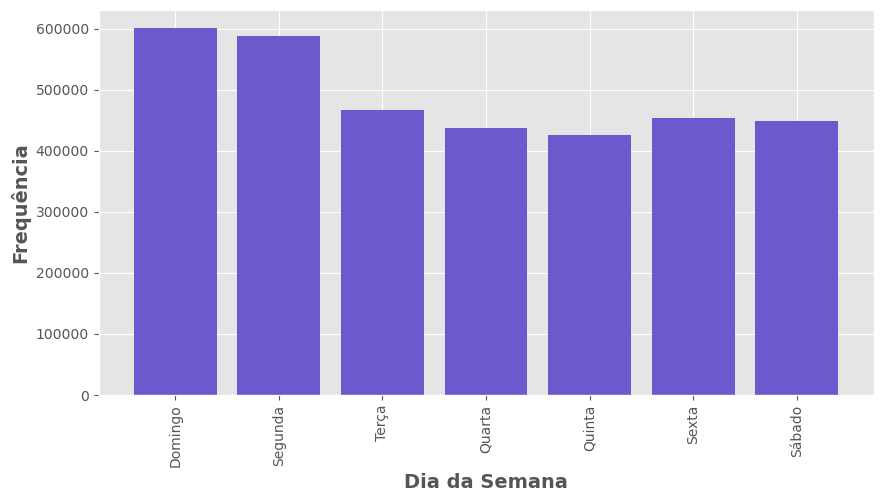

In [25]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [26]:
# Frequências de pedidos pela hora do dia
x = list(range(0,24))
y = []
for i in range(24):
    y.append(order[order['order_hour_of_day']==i].shape[0])

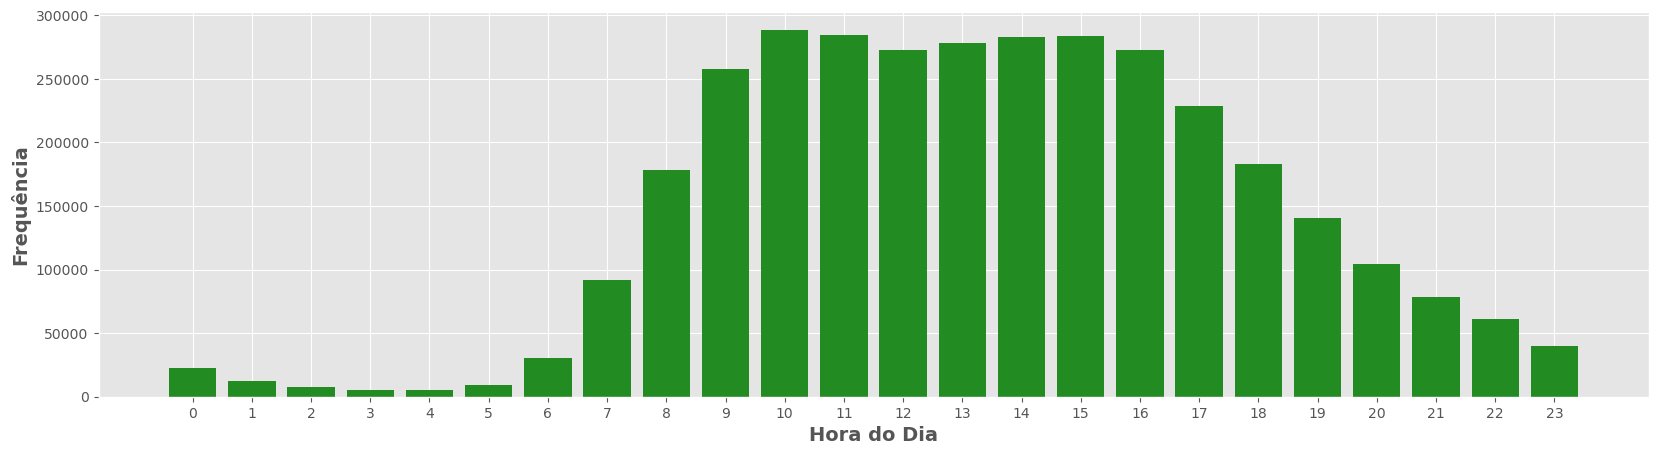

In [27]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 4- Qual o tamanho dos pedidos realizados?

In [28]:
# Calcular o tamanho do carrinho por pedido
cart_size = order_product_prior.groupby("order_id")["product_name"].count()

In [29]:
# Calcular a média
cart_size.mean()

10.088883421247614

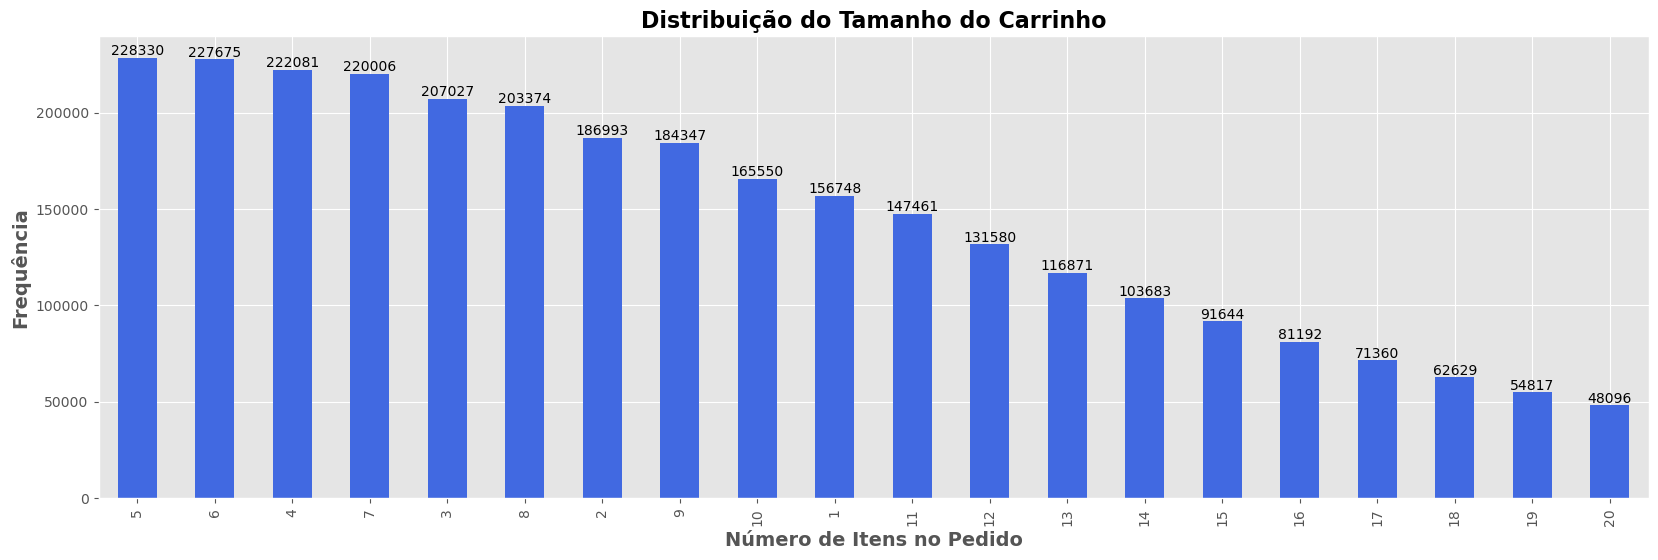

In [30]:
# Plot
sorted_cart_size = cart_size.value_counts().sort_values(ascending=False)
plt.figure(figsize=(20,6))
bars = sorted_cart_size[0:20].plot(kind="bar", color='royalblue')

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.xlabel('Número de Itens no Pedido', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.title('Distribuição do Tamanho do Carrinho', fontsize=16, fontweight='bold')
plt.show()

### 5- Qual o tempo médio entre os pedidos realizados?

In [31]:
# Calcular o tempo médio entre pedidos
days_between_orders = order.groupby("user_id")["days_since_prior_order"].count()

In [32]:
# Calcular o tempo médio entre pedidos
days_between_orders.mean()

15.590367054784224

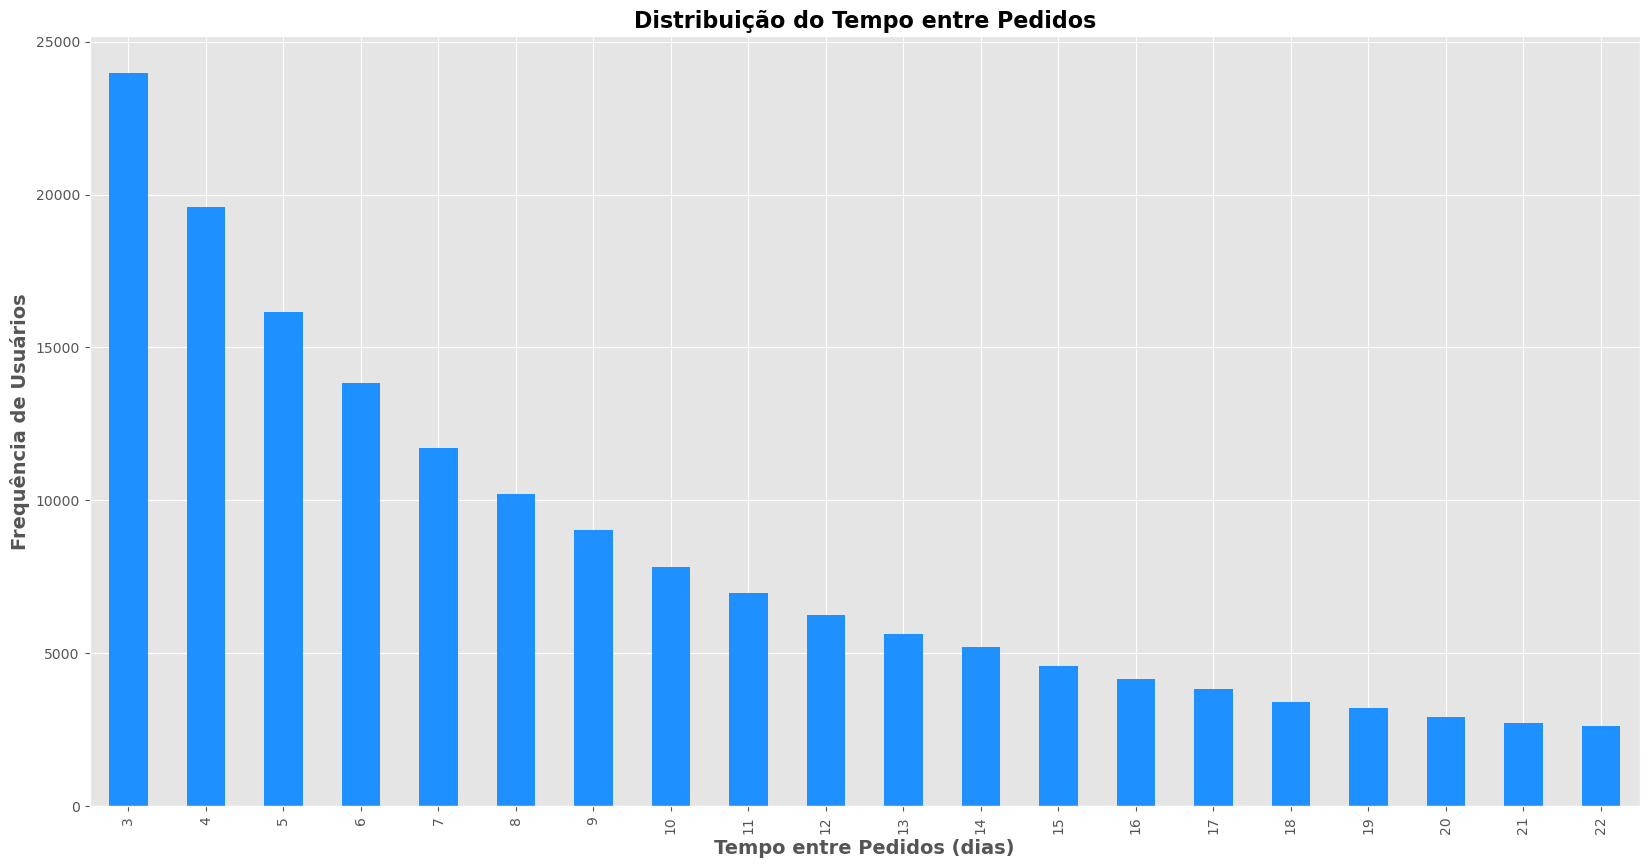

In [33]:
# Plot
sorted_days_between_orders = days_between_orders.value_counts().sort_values(ascending=False)
plt.figure(figsize=(20,10))
sorted_days_between_orders[0:20].plot(kind="bar", color='dodgerblue')
plt.xlabel('Tempo entre Pedidos (dias)', fontsize=14, fontweight='bold')
plt.ylabel('Frequência de Usuários', fontsize=14, fontweight='bold')
plt.title('Distribuição do Tempo entre Pedidos', fontsize=16, fontweight='bold')
plt.show()

### 6- Qual Departamento Tem o Maior Número de Pedidos?

In [34]:
# Contagem de pedidos por departamento
dept_cnt = order_product_prior['department'].value_counts()

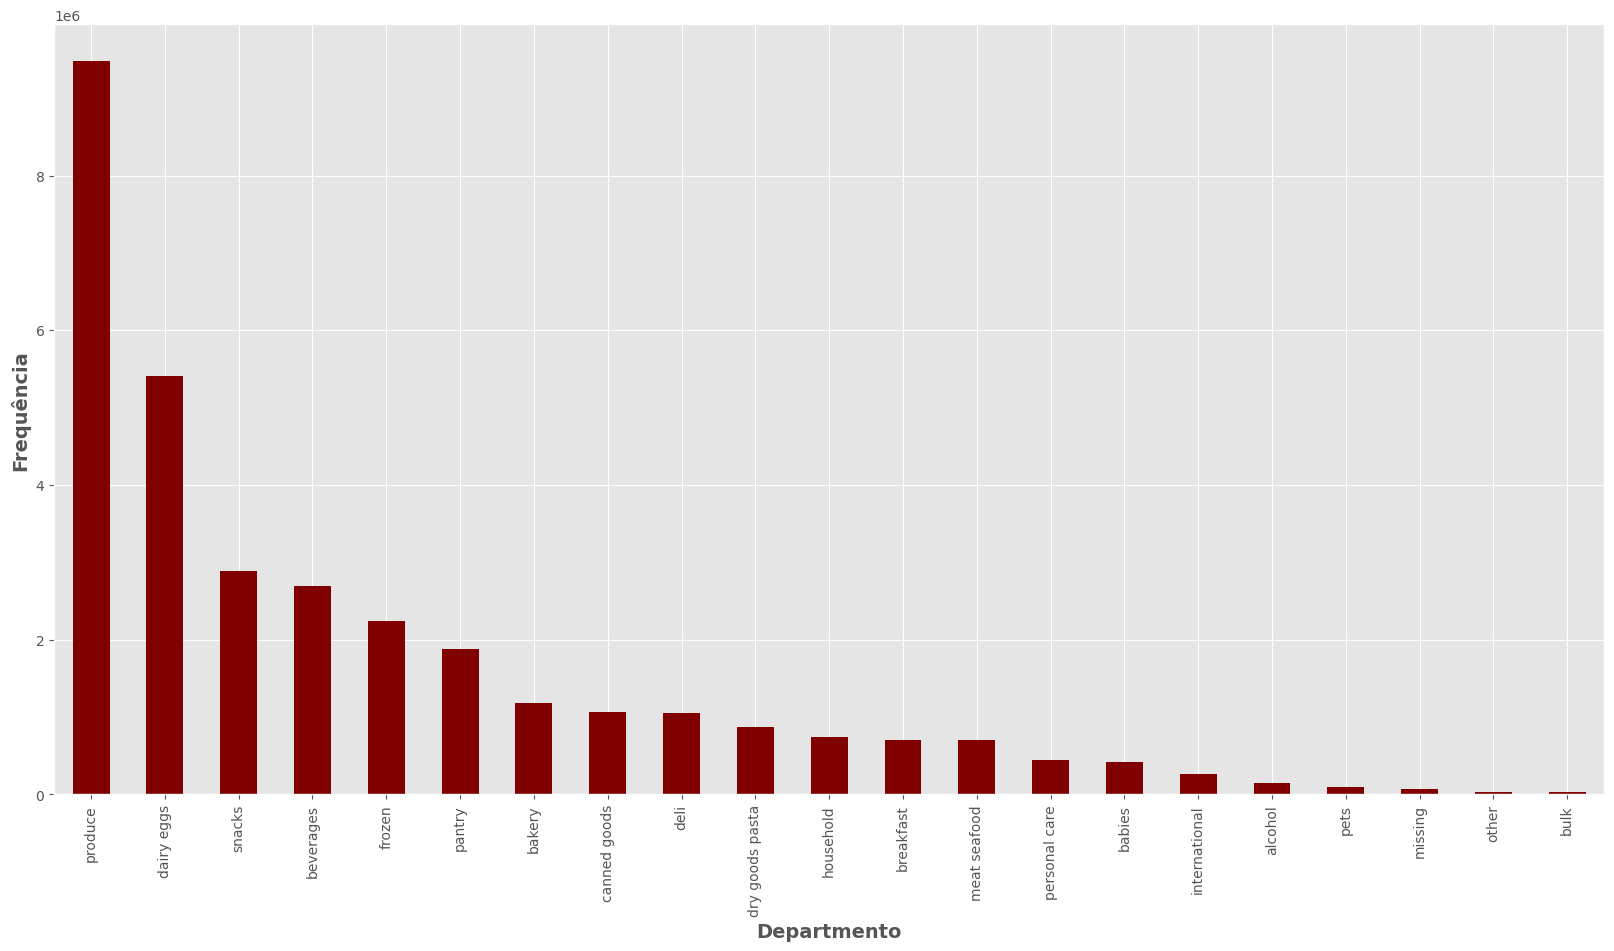

In [35]:
# Plot
fig = plt.figure(figsize = (20,10))
dept_cnt.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 7- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [36]:
# Os 20 principais corredores e sua frequência de pedidos
aisle_cnt = order_product_prior['aisle'].value_counts()

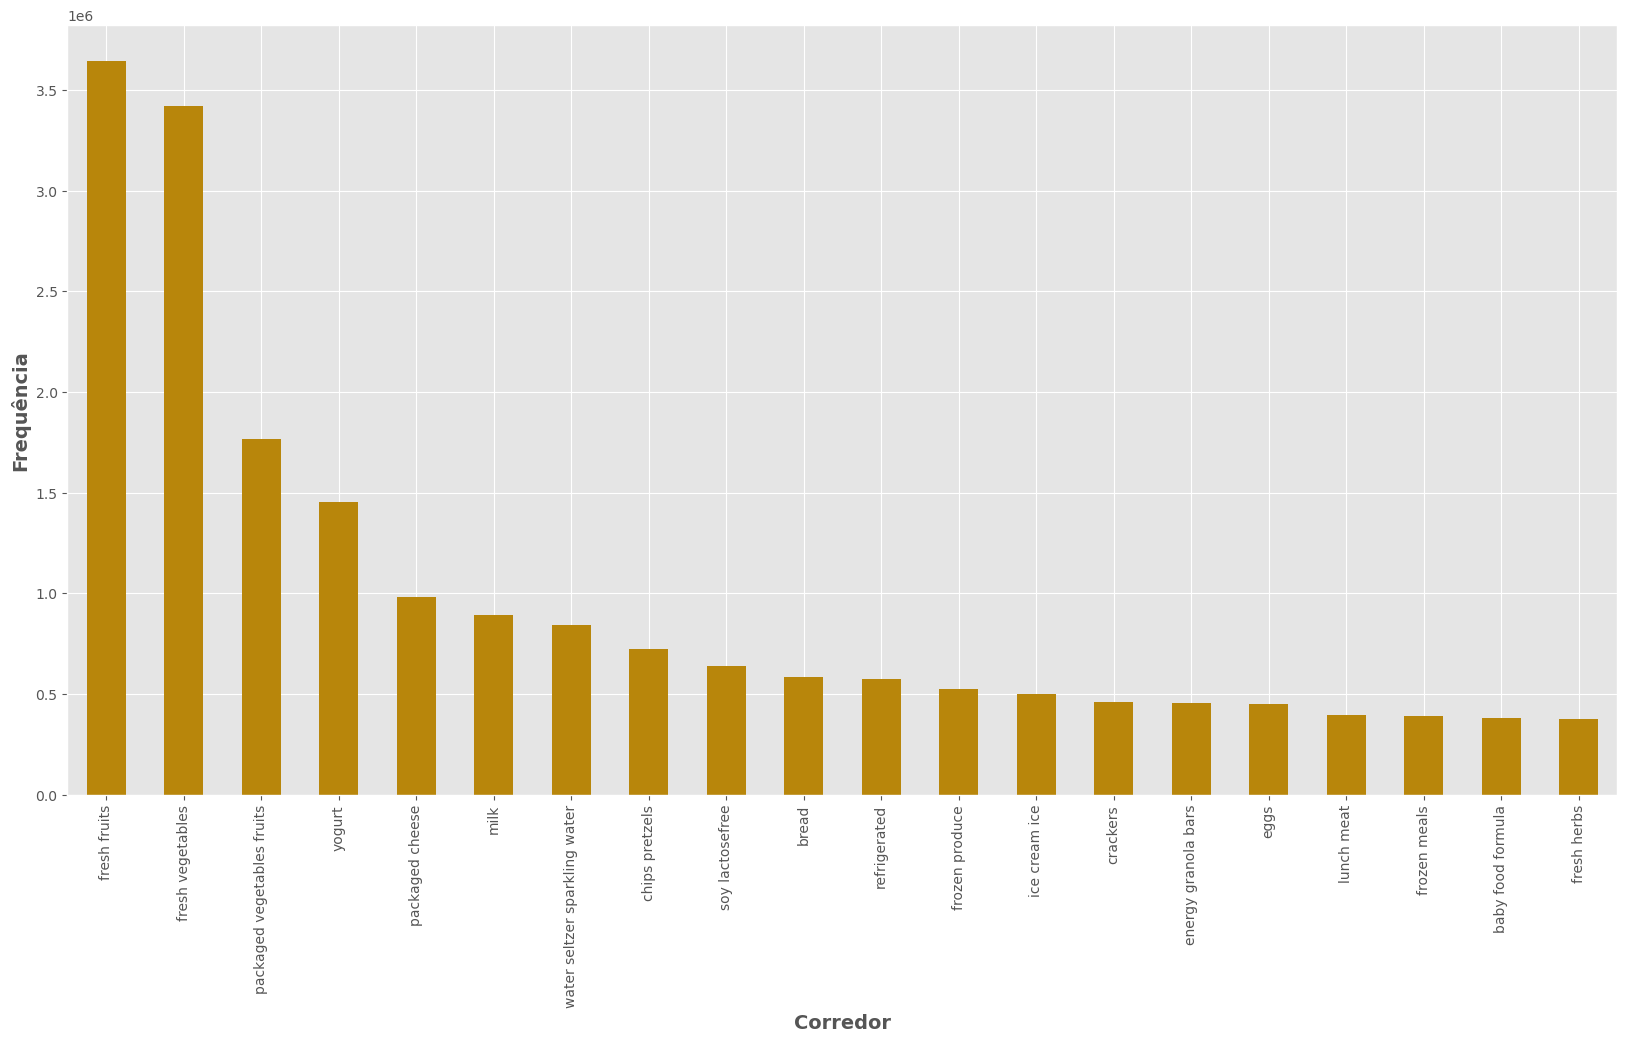

In [37]:
# Plot
fig = plt.figure(figsize = (20,10))
aisle_cnt[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 8- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [38]:
# Os 20 principais produtos por frequência de pedido
prod_cnt = order_product_prior['product_name'].value_counts()

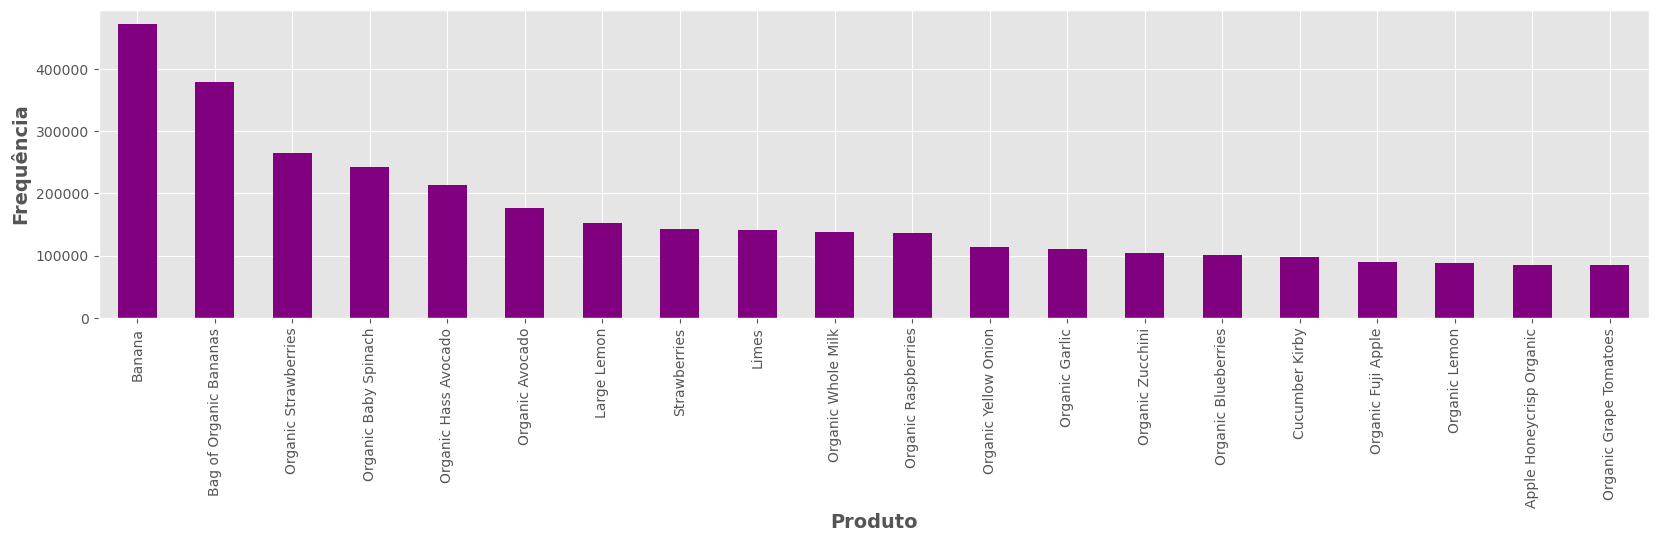

In [39]:
# Plot
fig = plt.figure(figsize = (20,4))
prod_cnt[0:20].plot(kind = "bar", color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

In [40]:
%%time
temp_df = order_product_prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


Wall time: 8.74 s


In [41]:
# Prepara as listas
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])    

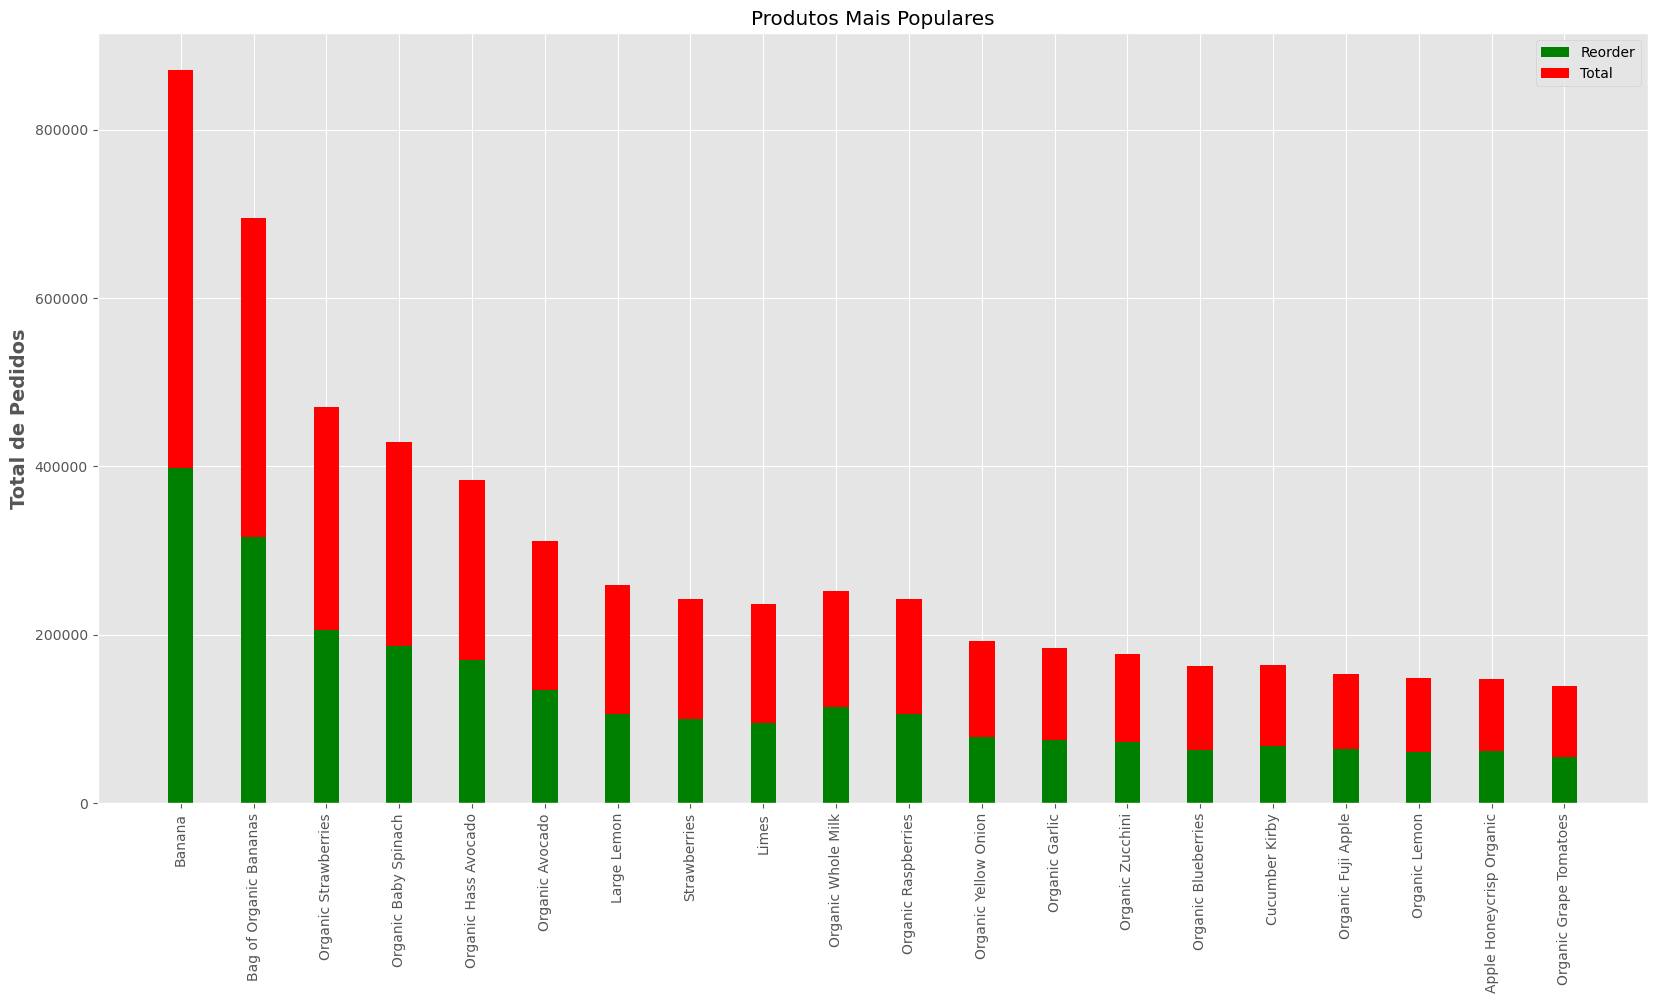

In [42]:
# Plot  
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 90)
plt.show()

### 9- Análise de Reorder Por Departamento ao Longo do Tempo

In [43]:
# Agrupando os dados por departamento e reorder
grouped_df = order_product_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


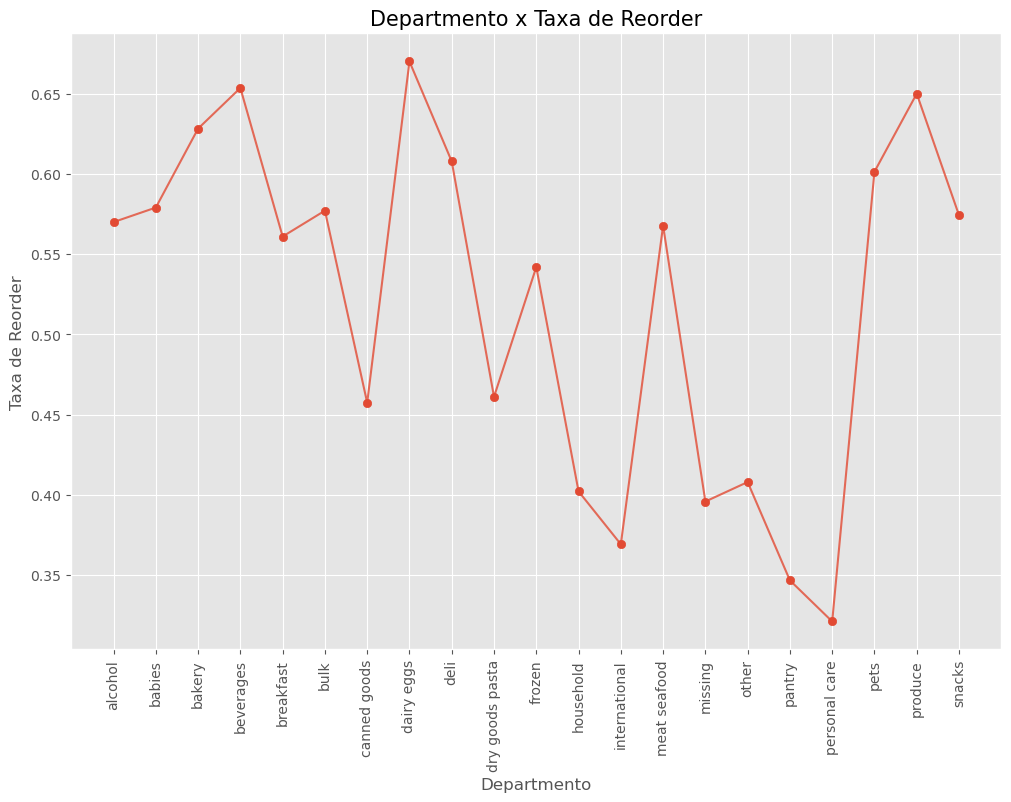

In [44]:
# Plot
plt.figure(figsize = (12,8))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 10- Análise de Reorder e Pedidos

In [45]:
%%time
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


Wall time: 2.72 s


In [46]:
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [47]:
# Listas
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

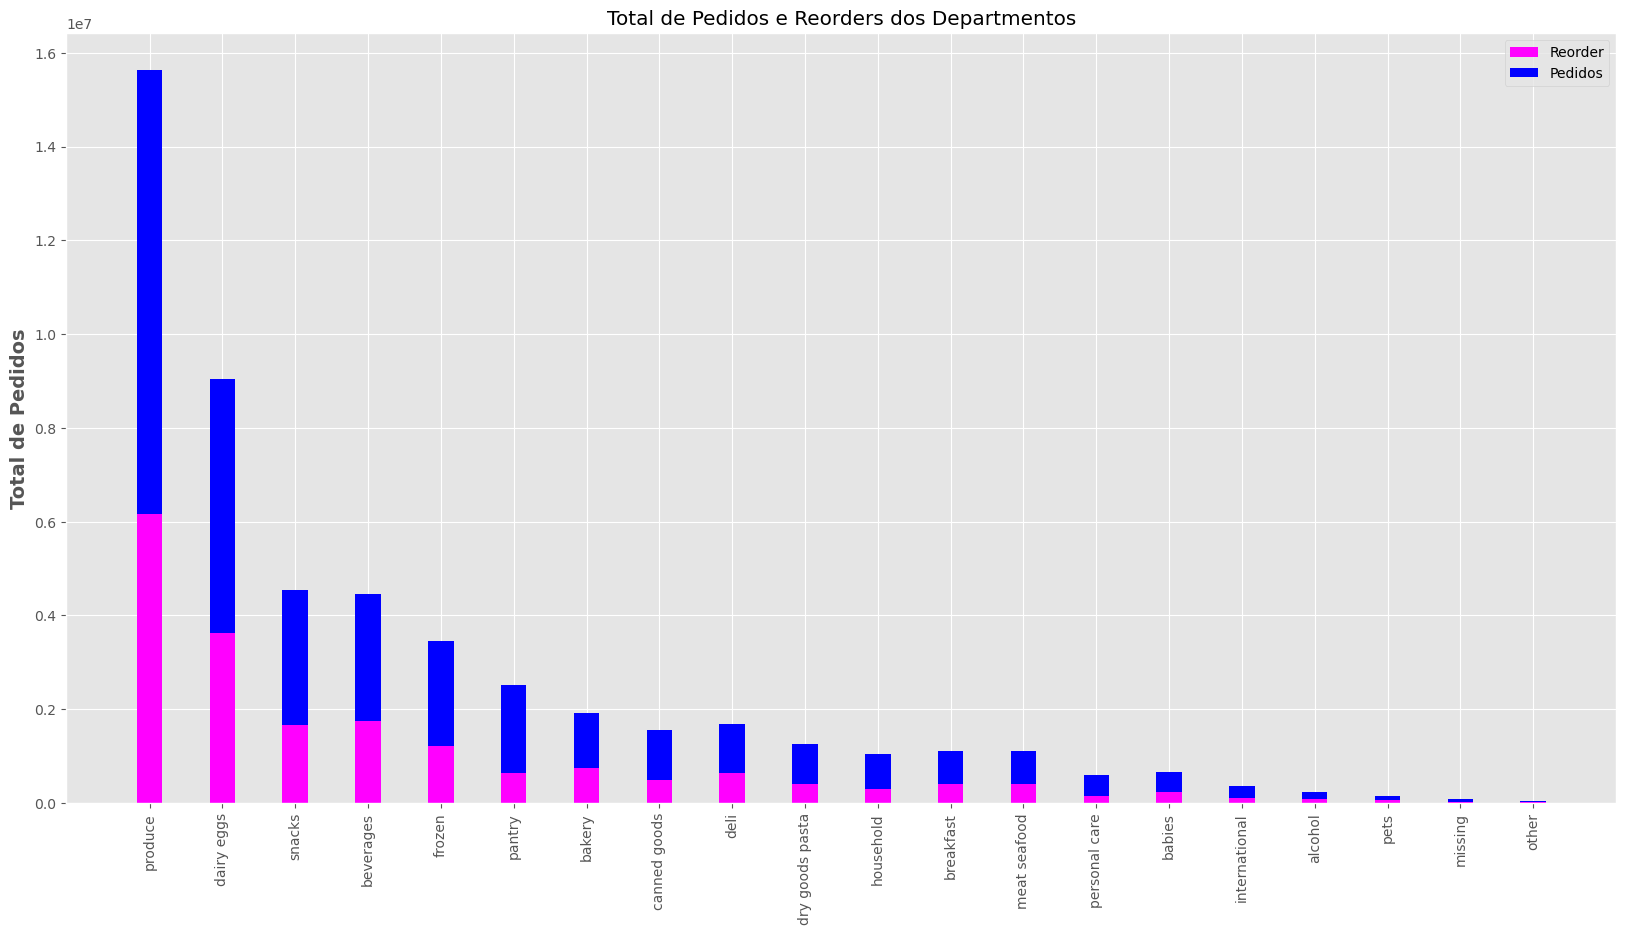

In [48]:
# Plot
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 90)
plt.show()

### 11- Análise de Reorder Por Corredor

In [49]:
grouped_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [50]:
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

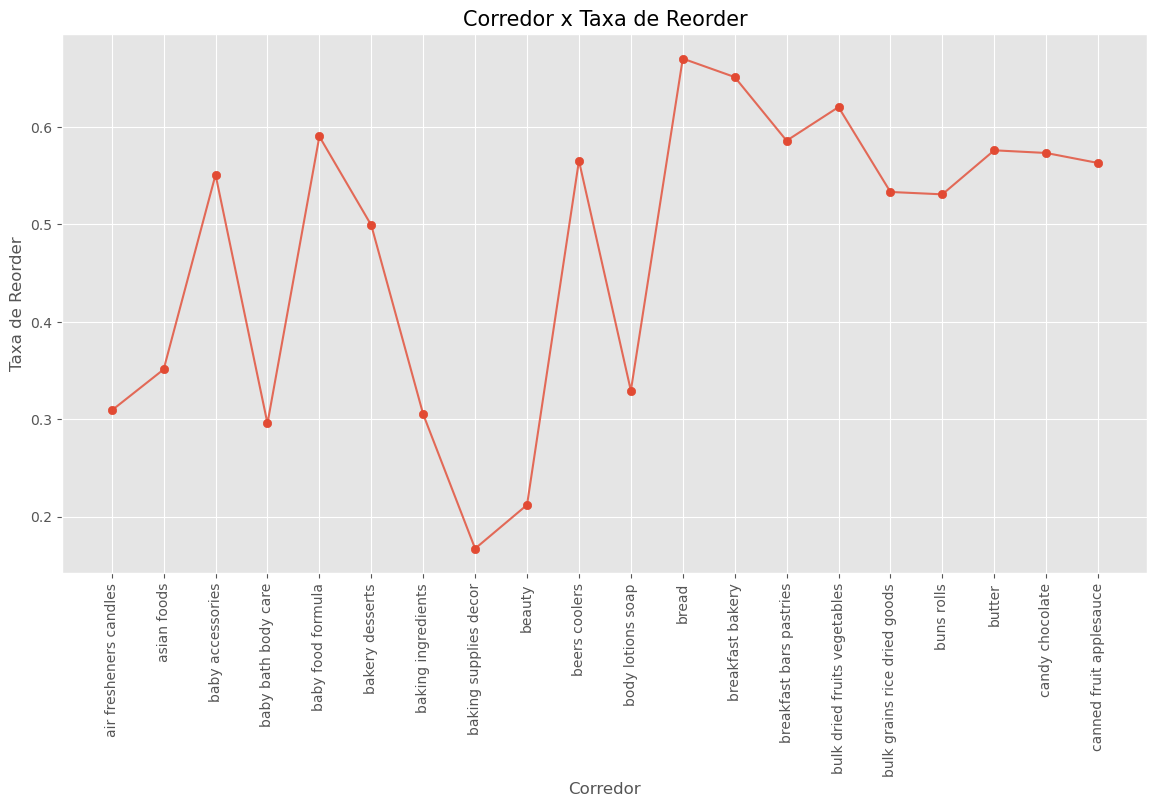

In [51]:
# Corredor x Taxa de Reorder
plt.figure(figsize=(14,7))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 12- Análise de Reorder Por Corredor (Total)

In [52]:
%%time
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


Wall time: 3.04 s


In [53]:
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [54]:
# Listas
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

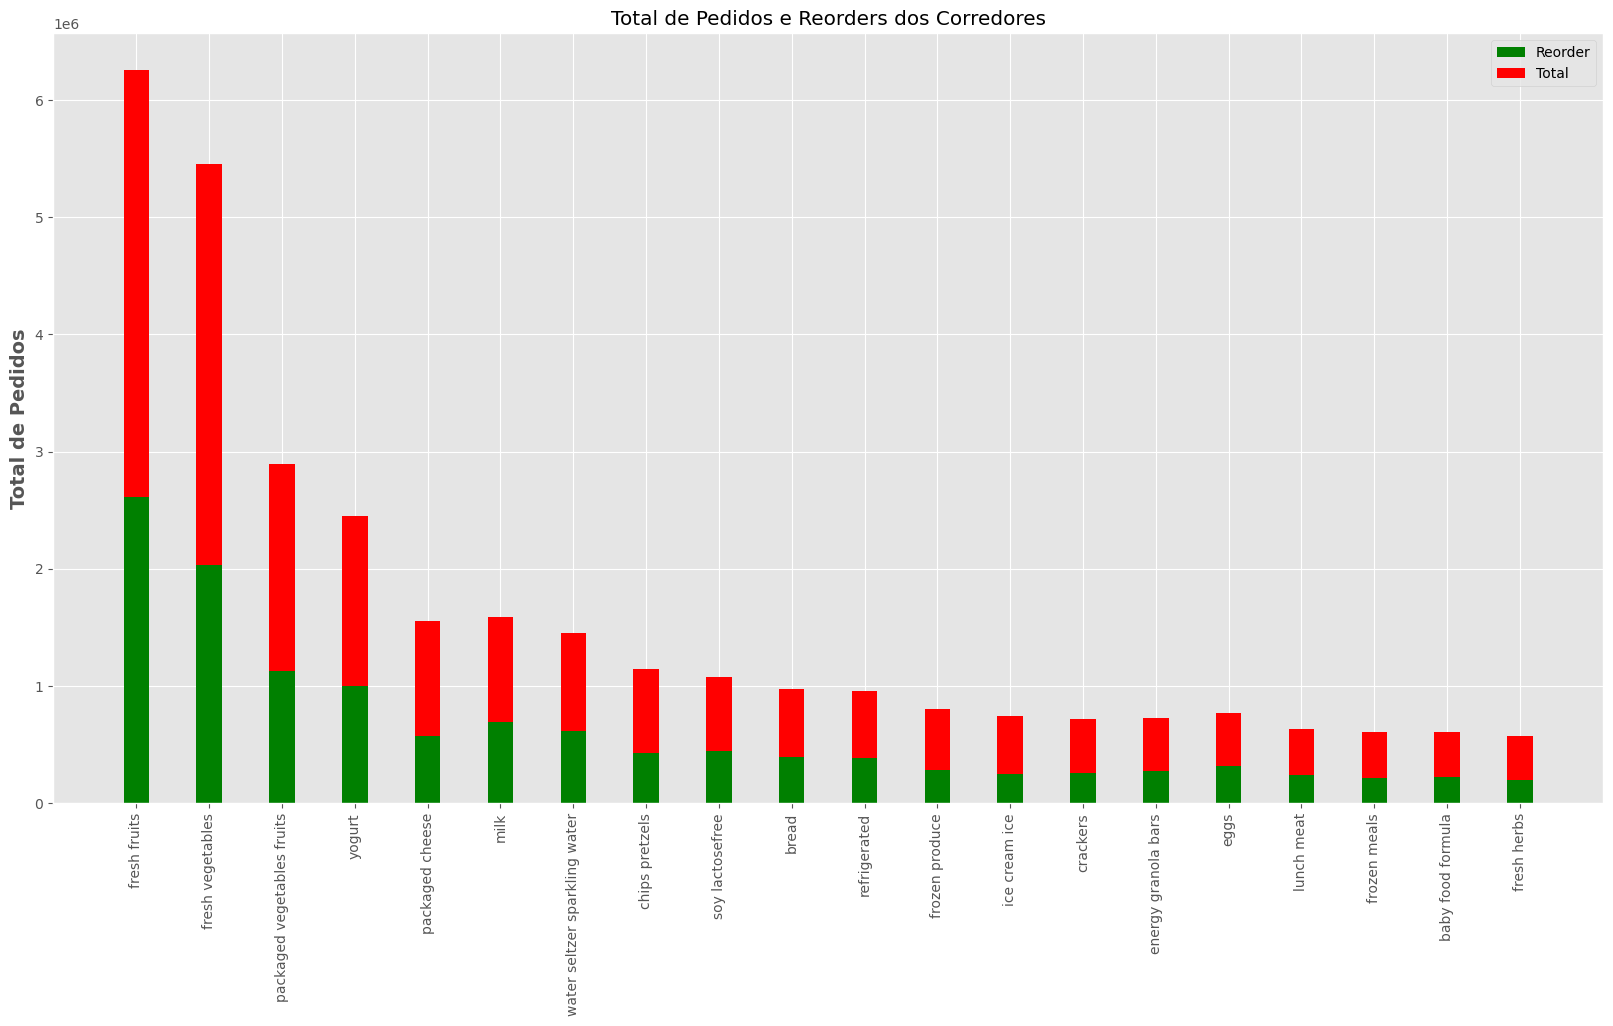

In [55]:
# Plot
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()

> Verifiquei a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [56]:
order_product_prior["add_to_cart_order_mod"] = order_product_prior["add_to_cart_order"].copy()
order_product_prior["add_to_cart_order_mod"].loc[order_product_prior["add_to_cart_order_mod"] > 70] = 70
grouped_df = order_product_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

In [57]:
grouped_df.head(10)

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
5,6,0.600420
6,7,0.585687
7,8,0.573247
8,9,0.561474
9,10,0.551018


#### Conclusão da Análise Estatística

- A Análise Estatística Descritiva revelou padrões significativos no comportamento dos consumidores. A maioria dos usuários realiza entre 4 e 10 pedidos, com uma tendência de diminuição na frequência à medida que o número de pedidos aumenta. No entanto, observa-se um aumento notável na frequência de pedidos quando os clientes atingem 100 compras.

- O domingo destaca-se como o dia da semana com o maior volume de compras, seguido pela segunda-feira, enquanto as quartas e quintas-feiras apresentam o menor número de pedidos. Quanto ao horário, o pico de compras ocorre entre 10h e 15h, com os maiores volumes registrados no final da manhã e início da tarde. Por outro lado, o período de menor movimento é entre 1h e 5h da manhã.

- Os produtos com maior frequência de pedidos são os de curta durabilidade, como frutas, verduras, leite e derivados. Entre os itens mais comprados, destacam-se bananas, morangos, espinafre e abacate.

- A análise da recompra indica que produtos essenciais do dia a dia, como pães, frutas e alimentos para bebês, apresentam altas taxas de recompra em intervalos curtos.

- Embora o tamanho médio do carrinho seja de 10 itens, a maioria dos pedidos contém de 3 a 7 itens. Além disso, a diversidade de produtos nos pedidos sugere que os consumidores tendem a repetir combinações semelhantes de compras.

- Por fim, o tempo médio entre os pedidos é de 15 dias, com a maior frequência observada em pedidos realizados a cada 3 dias, diminuindo à medida que o intervalo se estende.

- Esses insights podem ser utilizados para otimizar estratégias de marketing, personalizar recomendações e ajustar a operação logística da plataforma.

# Implementação do Algoritmo Apriori

## O que é o Algoritmo Apriori?
O Apriori é um algoritmo projetado para descobrir regras de associação em grandes bases de dados. Ele opera com base na ideia de que, se um conjunto de itens é frequente, então todos os seus subconjuntos também devem ser frequentes. O algoritmo funciona em duas etapas principais:

Geração de Itemsets Frequentes: O algoritmo identifica todos os conjuntos de itens (itemsets) que atendem a um critério de frequência mínima (support). Isso é feito em múltiplas passagens sobre os dados.

Geração de Regras de Associação: A partir dos itemsets frequentes, o Apriori gera regras de associação que podem ser interpretadas como "se um conjunto de itens é comprado, então outro conjunto de itens provavelmente também será comprado". Cada regra é avaliada com base em medidas como suporte, confiança e lift.

## Por que utilizar o Algoritmo Apriori?
Identificação de Padrões de Compra: O Apriori é amplamente utilizado em Market Basket Analysis para descobrir quais produtos são frequentemente comprados juntos. Isso pode ajudar no planejamento de marketing, promoções e layout de loja.

Simplicidade e Interpretabilidade: O algoritmo é relativamente simples de entender e implementar. As regras geradas são fáceis de interpretar, o que facilita a comunicação dos resultados para stakeholders.

Flexibilidade: O Apriori pode ser aplicado a diferentes tipos de dados e setores, como vendas no varejo, recomendações de produtos, análise de cliques em websites, entre outros.

## Implicações do Algoritmo Apriori
Custo Computacional: Embora o Apriori seja eficiente em muitos casos, ele pode se tornar computacionalmente caro em conjuntos de dados muito grandes, devido ao número de passagens necessárias e à geração de muitos itemsets. Isso pode ser mitigado utilizando abordagens de amostragem ou implementações otimizadas.

Limitações em Dados Escassos: O algoritmo pode ter dificuldades em encontrar padrões significativos em conjuntos de dados muito esparsos, onde poucos itens são comprados em cada transação.

Overfitting: Assim como em outros métodos de aprendizado de máquina, há o risco de overfitting, especialmente se a frequência mínima não for bem ajustada. Isso pode levar a regras que não são generalizáveis.

Métricas:

![title](imagens/regras.png)

Support = Fração de transações que contêm A e B.

![title](imagens/support.png)

Confidence = A frequência com que B aparece em transações que contêm apenas A.

![title](imagens/confidence.png)

Lift = Quanto aumentou nossa confiança de que B será comprado, dado que A foi comprado.

![title](imagens/lift.png)

> Agrupei os dados para aplicar o algoritmo Apriori e preparar o dataset com todas as transações.

In [58]:
%%time
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

Wall time: 23min 46s


In [59]:
order_grouped.shape

(3214874, 2)

In [60]:
order_grouped.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [61]:
# Listas
prod = []

In [62]:
%%time
for i in range(len(order_grouped[0])):
    prod.append(list(order_grouped.iloc[i][1]))

Wall time: 29min 21s


In [63]:
prod_ = prod

In [64]:
order_ = order_grouped[0]

In [65]:
# Prepara o dataframe
transactions = pd.DataFrame({'OrderID' : order_, 'Products' : prod_})

In [66]:
transactions.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


In [67]:
# Prepara a tupla com as transações
transactions_tup = [tuple(row) for row in transactions['Products'].tolist()]

### Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

In [68]:
st = datetime.now()
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)
print('Tempo de Execução : ', datetime.now() - st)

Tempo de Execução :  0:00:14.145552


In [69]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [70]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [71]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [72]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [73]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [74]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [75]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


### Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2

In [76]:
st = datetime.now()
itemsets_ap_1, rules_ap_1 = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)
print('Tempo de Execução: ', datetime.now() - st)

Tempo de Execução:  0:00:12.202115


In [77]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [78]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [79]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [80]:
# Loop
for i in range(len(temp1)):
    
    support_A1.append(itemsets_ap_1[1][tuple([temp1['itemA'][i],])] / 500000)
    
    support_B1.append(itemsets_ap_1[1][tuple([temp1['itemB'][i],])] / 500000)
    
    if tuple([temp1['itemA'][i],temp1['itemB'][i]]) in itemsets_ap_1[2].keys():
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemA'][i],temp1['itemB'][i]])] / 500000)
    else:
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemB'][i],temp1['itemA'][i]])] / 500000)
    
    confidence_AB1.append(support_AB1[i] / support_A1[i])
    
    lift_AB1.append(support_AB1[i] / (support_A1[i] * support_B1[i]))

In [81]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [82]:
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


In [83]:
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


# Conclusão

Aplicando Matemática e Estatística via programação executamos uma análise de MBA gerando como resultado as regras de associação entre os produtos com diferentes métricas.

- A relação mais forte identificada foi entre Organic Fuji Apple e Banana, com uma confiança de 38,04% e um lift de 2,58, indicando que a compra de um Organic Fuji Apple aumenta significativamente a probabilidade de compra de Banana.

- Outras relações relevantes incluem Honeycrisp Apple → Banana (35,65% de confiança), Cucumber Kirby → Banana (33,17% de confiança) e Organic Large Extra Fancy Fuji Apple → Bag of Organic Bananas (31,36% de confiança)

- A Banana apareceu como um dos itens mais associados, sendo recomendada junto a vários produtos orgânicos, como Organic Raspberries, Organic Strawberries e Organic Baby Spinach.

- O produto Bag of Organic Bananas também teve forte associação com itens como Organic Large Extra Fancy Fuji Apple, Organic Hass Avocado e Organic Raspberries, reforçando a tendência de compras de produtos naturais e saudáveis juntos.

- O lift mostrou que algumas associações são mais relevantes do que apenas ocorrências aleatórias. Por exemplo, a relação entre Organic Cilantro e Limes teve um lift de 5,74, indicando uma forte ligação entre esses produtos, apesar da confiança de apenas 25%.

##### Os resultados mostram que clientes que compram frutas e vegetais orgânicos têm grande probabilidade de comprar Bananas e produtos relacionados. Essas informações podem ser usadas para otimizar recomendações, promoções e organização de produtos no supermercado, maximizando vendas com base nos padrões de compra dos clientes.